In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

def get_plot_config(col, limit=True):
    use_log = "h_" in col
    if not limit:
        return use_log, None, None, None, None
    ymax = 30
    xmax = 4
    ylim_linear = (0, ymax)
    ylim_log = (1, 10000)
    ylim = ylim_linear if "cd_" in col else ylim_log
    xlim = (0, xmax - 1)
    yticks_linear = range(0, ymax, 5)
    yticks_log = None
    yticks = yticks_linear if "cd_" in col else None
    xticks = range(xmax)
    return use_log, ylim, yticks, xlim, xticks
    

In [37]:
summary = pd.read_csv("../PCCArena/experiments/summary.csv")
summary.head()
summary.datasets.unique()
# reduced = summary["algs", "datasets",]
# display(summary[summary.datasets == "s3dis"])
datasets = ["CAPOD", "s3dis", "blensor_no_noise", "blensor"]

col2label = {
#     "acd12_p2pt": "Assymetric Chamfer Distance 1-2 (Point-to-Point)",
#     "acd12_p2pl": "Assymetric Chamfer Distance 1-2 (Point-to-Plane)",
#     "acd21_p2pt": "Assymetric Chamfer Distance 2-1 (Point-to-Point)",
#     "acd21_p2pl": "Assymetric Chamfer Distance 2-1 (Point-to-Plane)",

    "cd_p2pt": "Chamfer Distance (Point-to-Point)",
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
    "h_p2pt": "Hausdorff Distance (Point-to-Point)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)"

}

reduced = summary[["datasets"] + list(col2label.keys())].groupby("datasets").std()
# display(reduced)
summary[summary["datasets"] == "s3dis"]["pc_file"].iloc[0]

'/itf-fi-ml/home/branisj/PCCArena/experiments/Draco/s3dis/r1/dec/Area_5_office_23.ply'

In [39]:
summary = pd.read_csv("../PCCArena/experiments/summary.csv")

capod = summary.query('algs')
capod = capod[0.45 < capod.bpp][capod.bpp < 0.55]
means = capod.groupby(["algs", "datasets"]).mean()
std = capod.groupby(["algs", "datasets"]).std()
means = means.reset_index()

p = means.pivot(index='datasets', columns='algs', values='cd_p2pt')
display(p)
p.plot(kind="bar", y=["cd_p2pt"], grid=True)


<ipython-input-39-040f3e2d265b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  capod = capod[0.45 < capod.bpp][capod.bpp < 0.55]


algs,Draco,GPCC,GeoCNNv2,PCGCv1
datasets,,,,
CAPOD,15.848253,1.578479,NaN,8.537522
Debug_SNC,NaN,NaN,1.65694,NaN
Sample_SNC,NaN,NaN,1.64819,NaN
blensor,NaN,3.265468,NaN,13.778377
blensor_no_noise,NaN,1.404417,NaN,NaN
s3dis,15.477756,1.776714,NaN,74.926000


KeyError: "None of [Index(['cd_p2pt'], dtype='object', name='algs')] are in the [columns]"

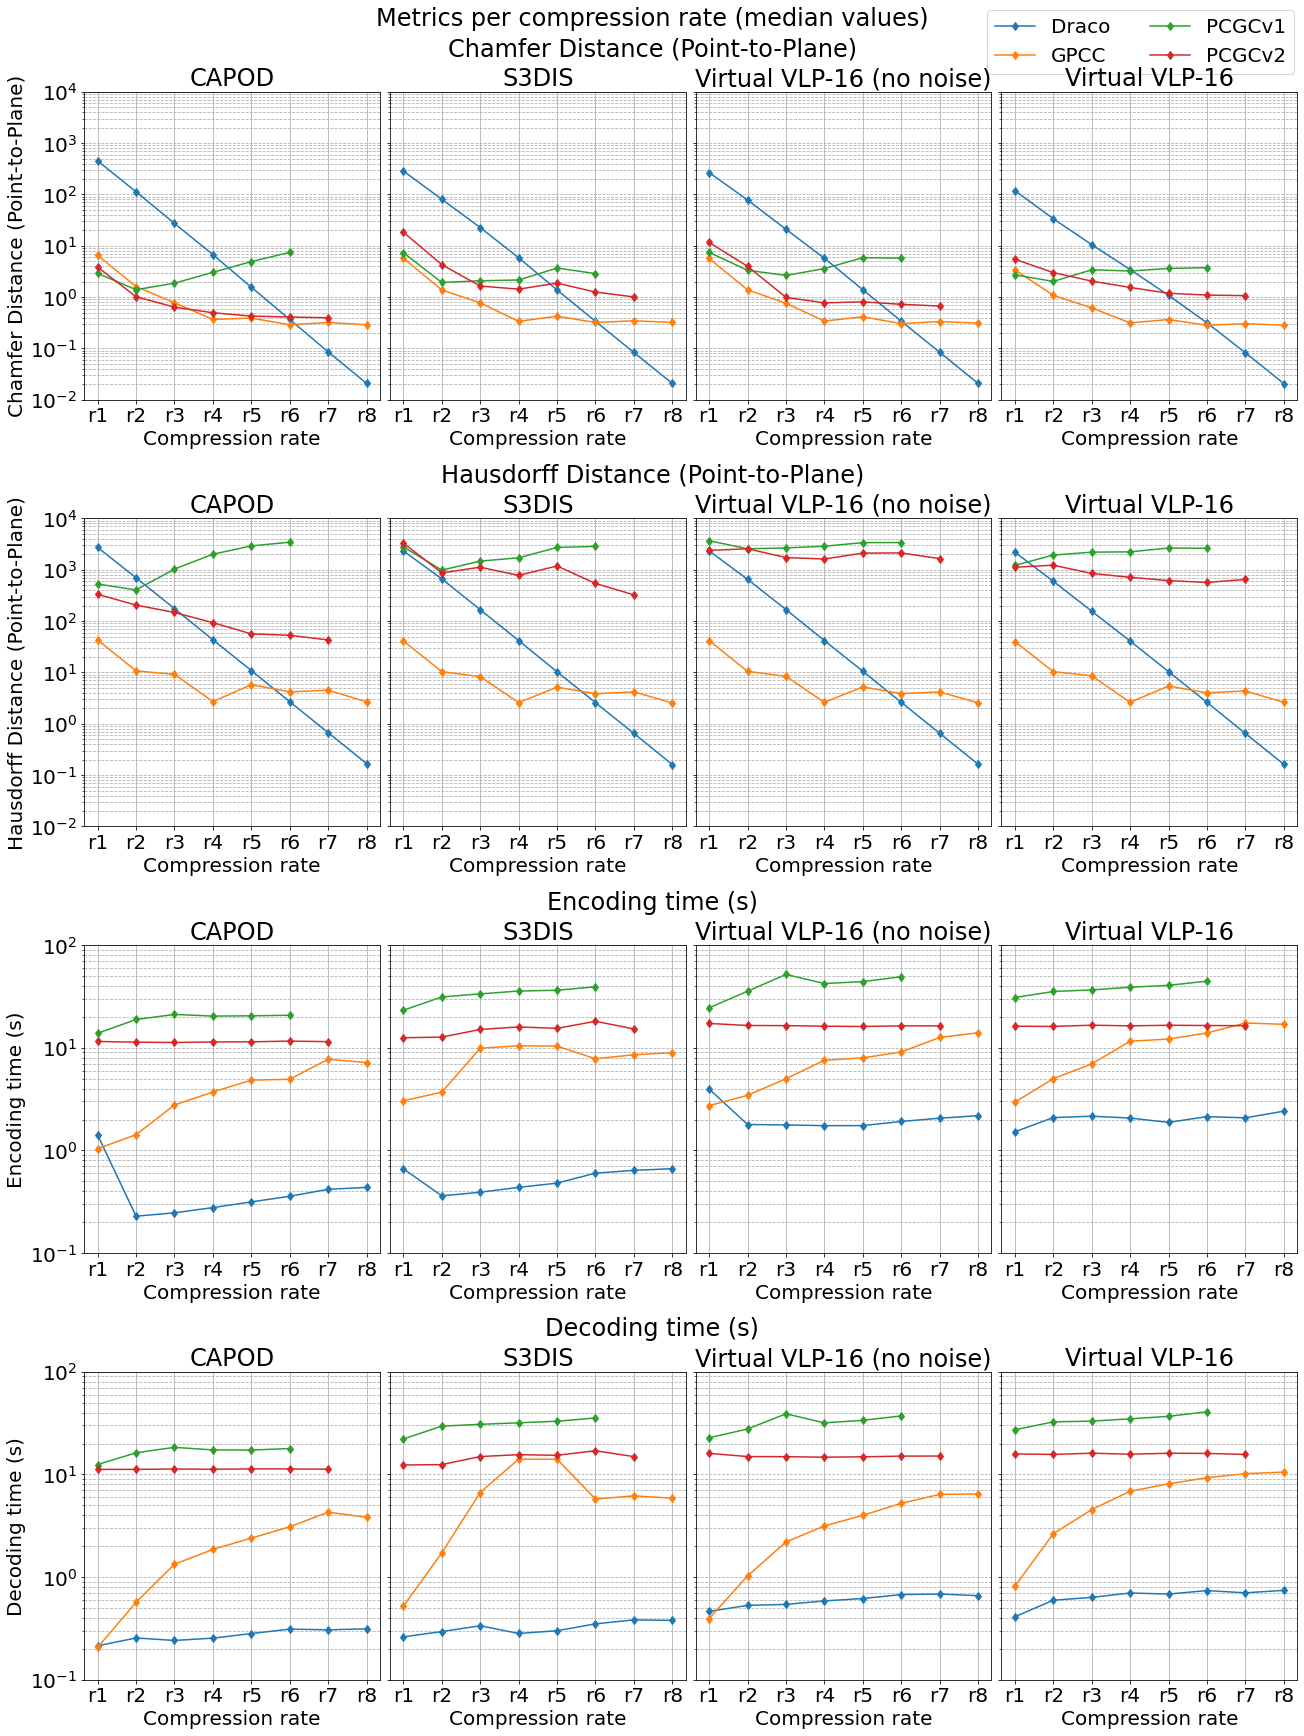

In [675]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

col2label = {
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)",
    "encT": "Encoding time (s)",
    "decT": "Decoding time (s)"
}

dataset2label = {
    "CAPOD": "CAPOD",
    "s3dis": "S3DIS",
    "blensor_no_noise": "Virtual VLP-16 (no noise)",
    "blensor": "Virtual VLP-16"
}

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

relevant_cols = list(col2label.keys())
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(18)
fig.set_figheight(24)
# fig.tight_layout()
fig.suptitle("Metrics per compression rate (median values)")
# fig.subplots_adjust(top=0.8)

subfigs = fig.subfigures(nrows=len(relevant_cols), ncols=1)

summary = summary[(summary["cd_p2pl"].notna()) & (summary["h_p2pl"].notna())]

for i, subfig in enumerate(subfigs):
    col = relevant_cols[i]
    axs = subfig.subplots(nrows=1, ncols=len(datasets), sharey=True)
    subfig.suptitle(f'{col2label[col]}')
    for j, ax in enumerate(axs):

        dataset = datasets[j]
        filtered = summary[summary.datasets == dataset]
        for key, grp in filtered.groupby('algs',  sort=False):
            means = grp.groupby("rate").median().reset_index()
            ylim = (0.01, 10000) if "h_" in col or "cd_" in col else (0.1,100)
            this_axis = means.plot(ax=ax, x="rate", y=col,  xticks=range(8), ylim=ylim, title=dataset2label[dataset], kind="line", marker=alg2marker[alg], logy=True, ylabel='', grid=True)
            this_axis.set_xticklabels(labels=[f"r{x}" for x in range(1, 9)])
            this_axis.set_ylabel(f'{col2label[col]}')
            this_axis.set_xlabel("Compression rate")
            this_axis.get_legend().remove()
            this_axis.yaxis.grid(True, which='both', linestyle='--')
            this_axis.xaxis.grid(True)
fig.legend(['Draco', 'GPCC', 'PCGCv1', 'PCGCv2'], loc="upper right", ncol=2, fancybox=True)
fig.savefig("plots/arena_metric_per_rate.png", bbox_inches='tight', pad_inches=1)


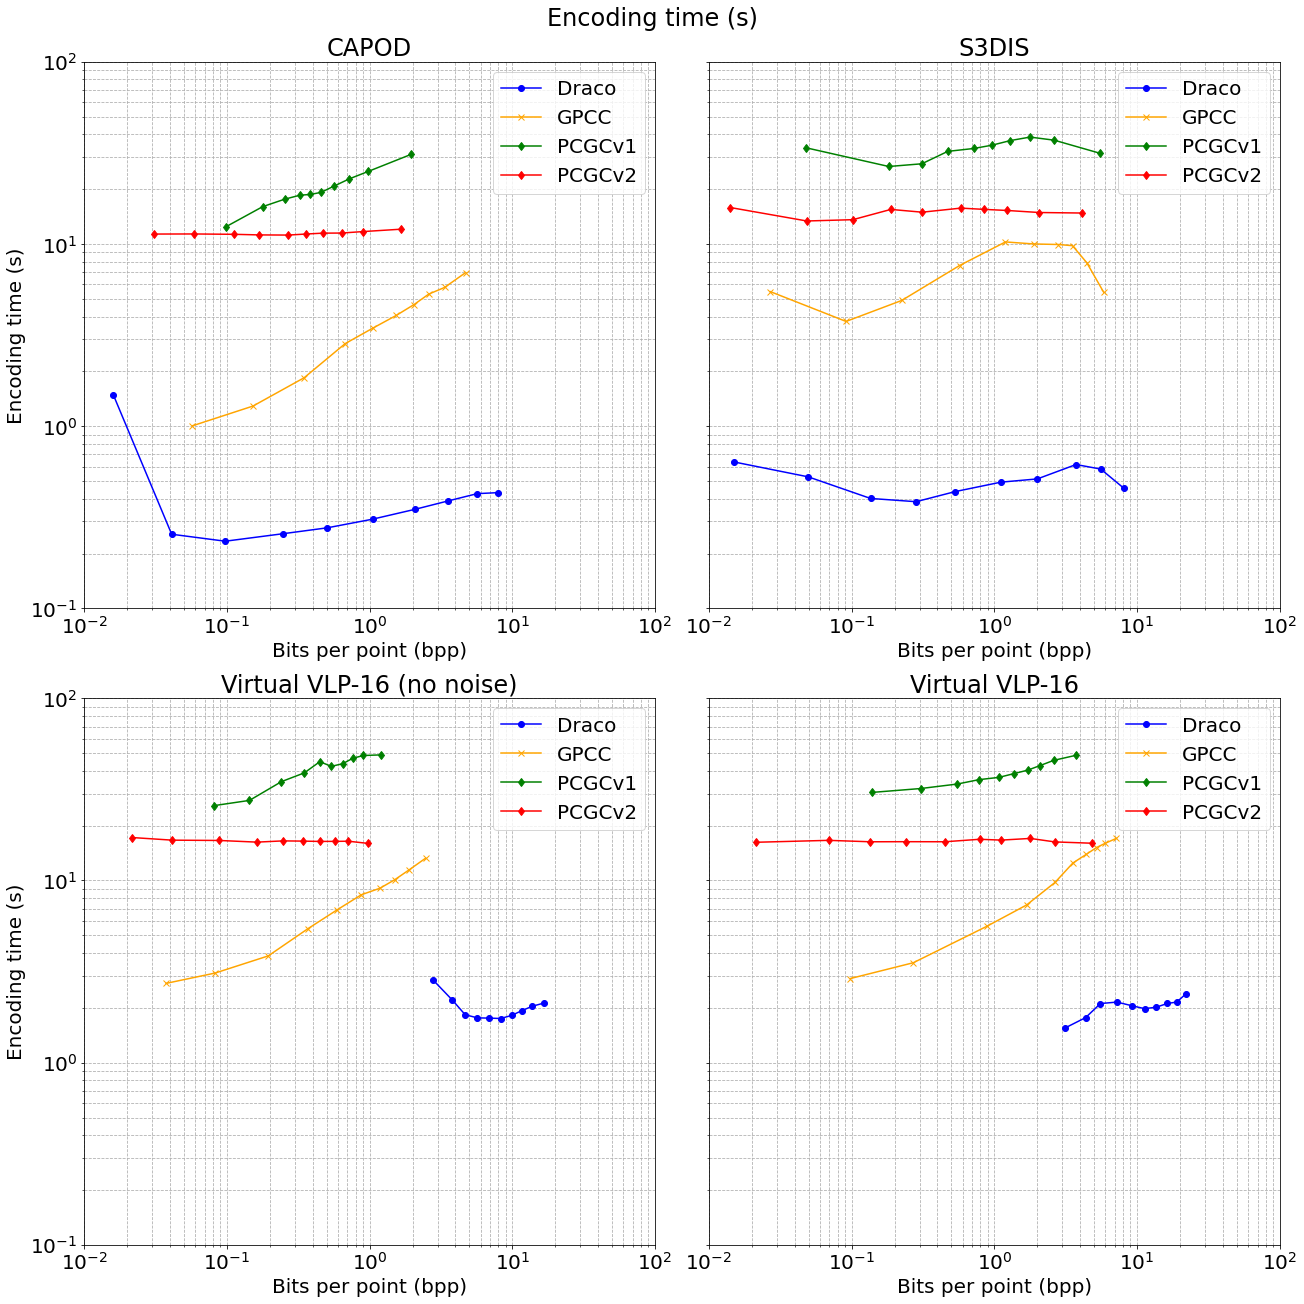

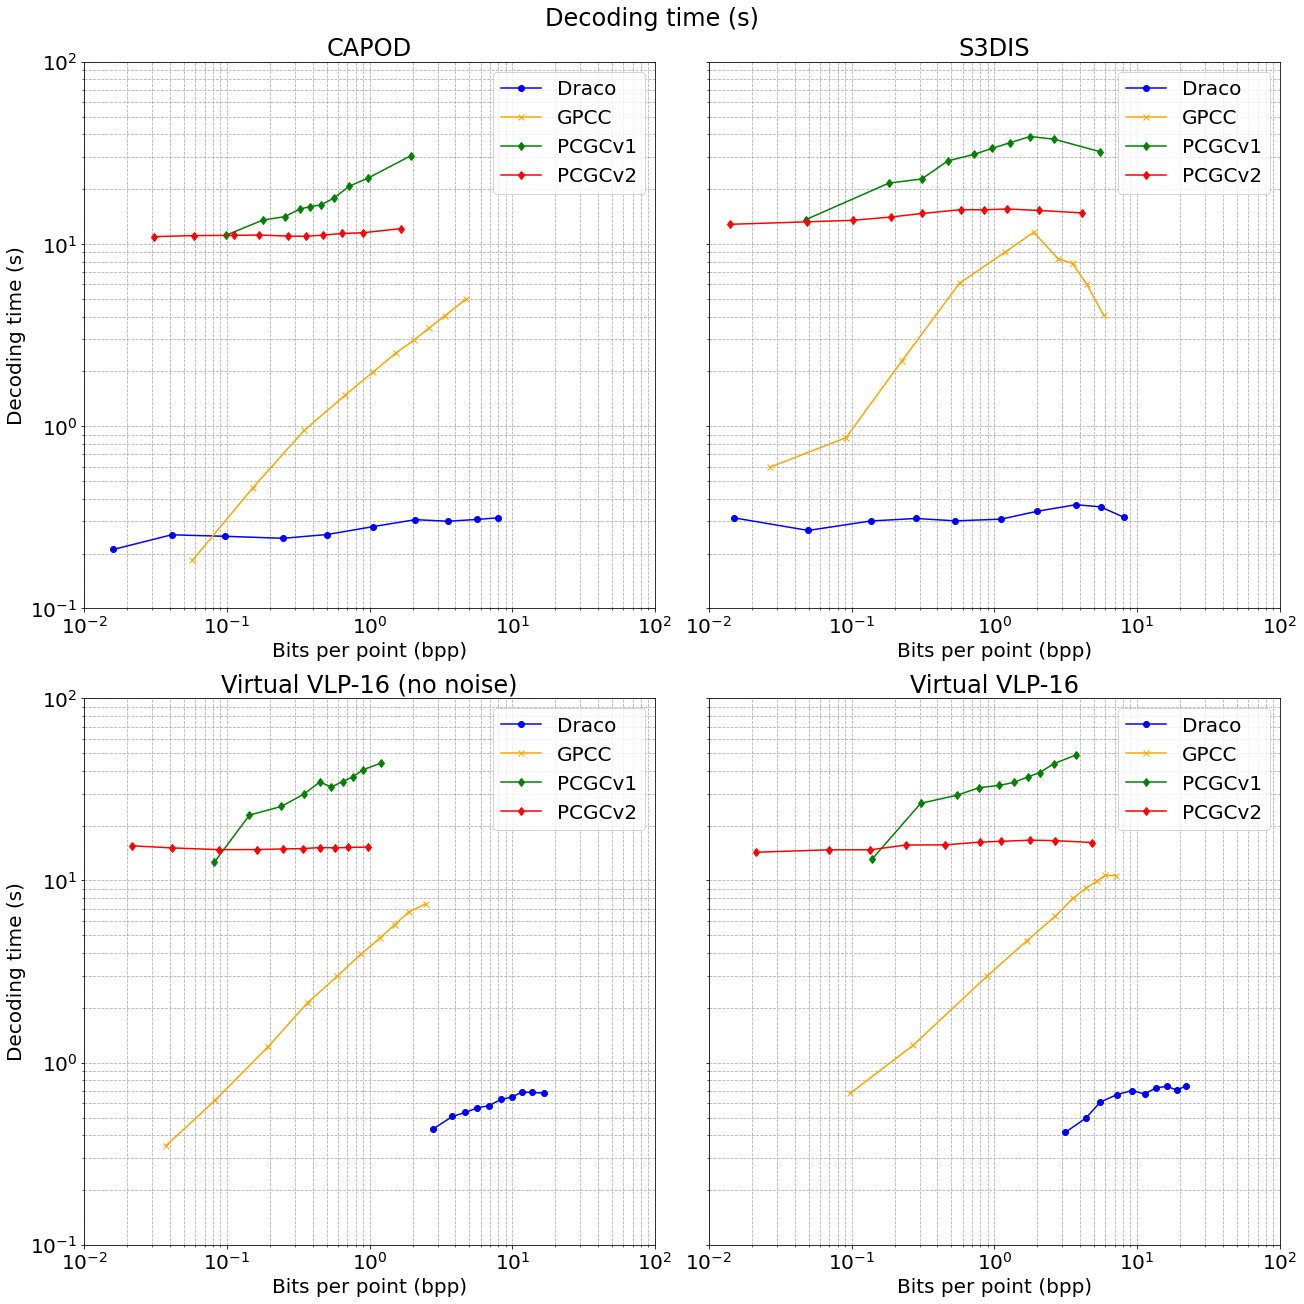

In [641]:
# try to recreate the metric/bpp graphs from the paper
# encoding time to bpp per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")


col2label = {
    "encT": "Encoding time (s)",
    "decT": "Decoding time (s)"    
}

relevant_cols = list(col2label.keys())
dataset2label = {
    "CAPOD": "CAPOD",
    "s3dis": "S3DIS",
    "blensor_no_noise": "Virtual VLP-16 (no noise)",
    "blensor": "Virtual VLP-16"
}
alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

summary = summary[(summary["cd_p2pl"].notna()) & (summary["h_p2pl"].notna())]
summary = summary.set_index(["algs", "datasets", "rate"])


for col in relevant_cols:
    fig, axes = plt.subplots(figsize=(18, 18), nrows=2, ncols=2, constrained_layout=True, sharey=True)
    fig.suptitle(col2label[col])
    for i, dataset in enumerate(datasets):   
        filtered = summary[summary.index.isin([dataset], level=1)].reset_index()
        for key, grp in filtered.groupby(['algs']):
            grp = grp[["bpp", col]].reset_index()            
            bins = pd.qcut(grp['bpp'], 10)
            means = grp.groupby(bins).median()
            use_log,ylim, yticks, xlim, xticks = get_plot_config(col, limit=False)            
            this_ax = means.plot(ax=axes[i//2, i%2], title=dataset2label[dataset], kind="line", c=alg2color[key], x='bpp', logy=True, logx=True, ylim=(0.1, 100), xlim=(0.01, 100), xticks=xticks, yticks=yticks, y=col, marker=alg2marker[key], ylabel=col2label[col], grid=True, label=key)
            this_ax.set_xlabel("Bits per point (bpp)")
            this_ax.yaxis.grid(True, which='both', linestyle='--')
            this_ax.xaxis.grid(True, which='both', linestyle='--')
    fig.savefig(f"plots/arena_{col}_per_bpp.png", bbox_inches='tight', pad_inches=1)

    

In [49]:
from pathlib import Path

summary = pd.read_csv("../PCCArena/experiments/summary.csv")
elongations = pd.read_csv("elongations.csv")
scanned_datasets = ["blensor_no_noise", "blensor"]

def get_filename(filepath):
    filename = Path(filepath).name
    if filename.startswith("Area"):
        return filename
    elif any(d in filepath for d in scanned_datasets):
        without_ext = filename.replace(".ply","")
        area = without_ext[-1]
        without_ext = without_ext[:-2]
        return f"Area_{area}_{without_ext}.ply"
    else:
        return filename
summary["room"] = summary["pc_file"].map(get_filename)
full = pd.merge(summary, elongations, how="outer", on=['room'])
full.to_hdf('data_with_elongations.h5', key='e')  

/itf-fi-ml/home/branisj/PCCArena/experiments/Draco/s3dis/r1/dec/Area_2_storage_4.ply


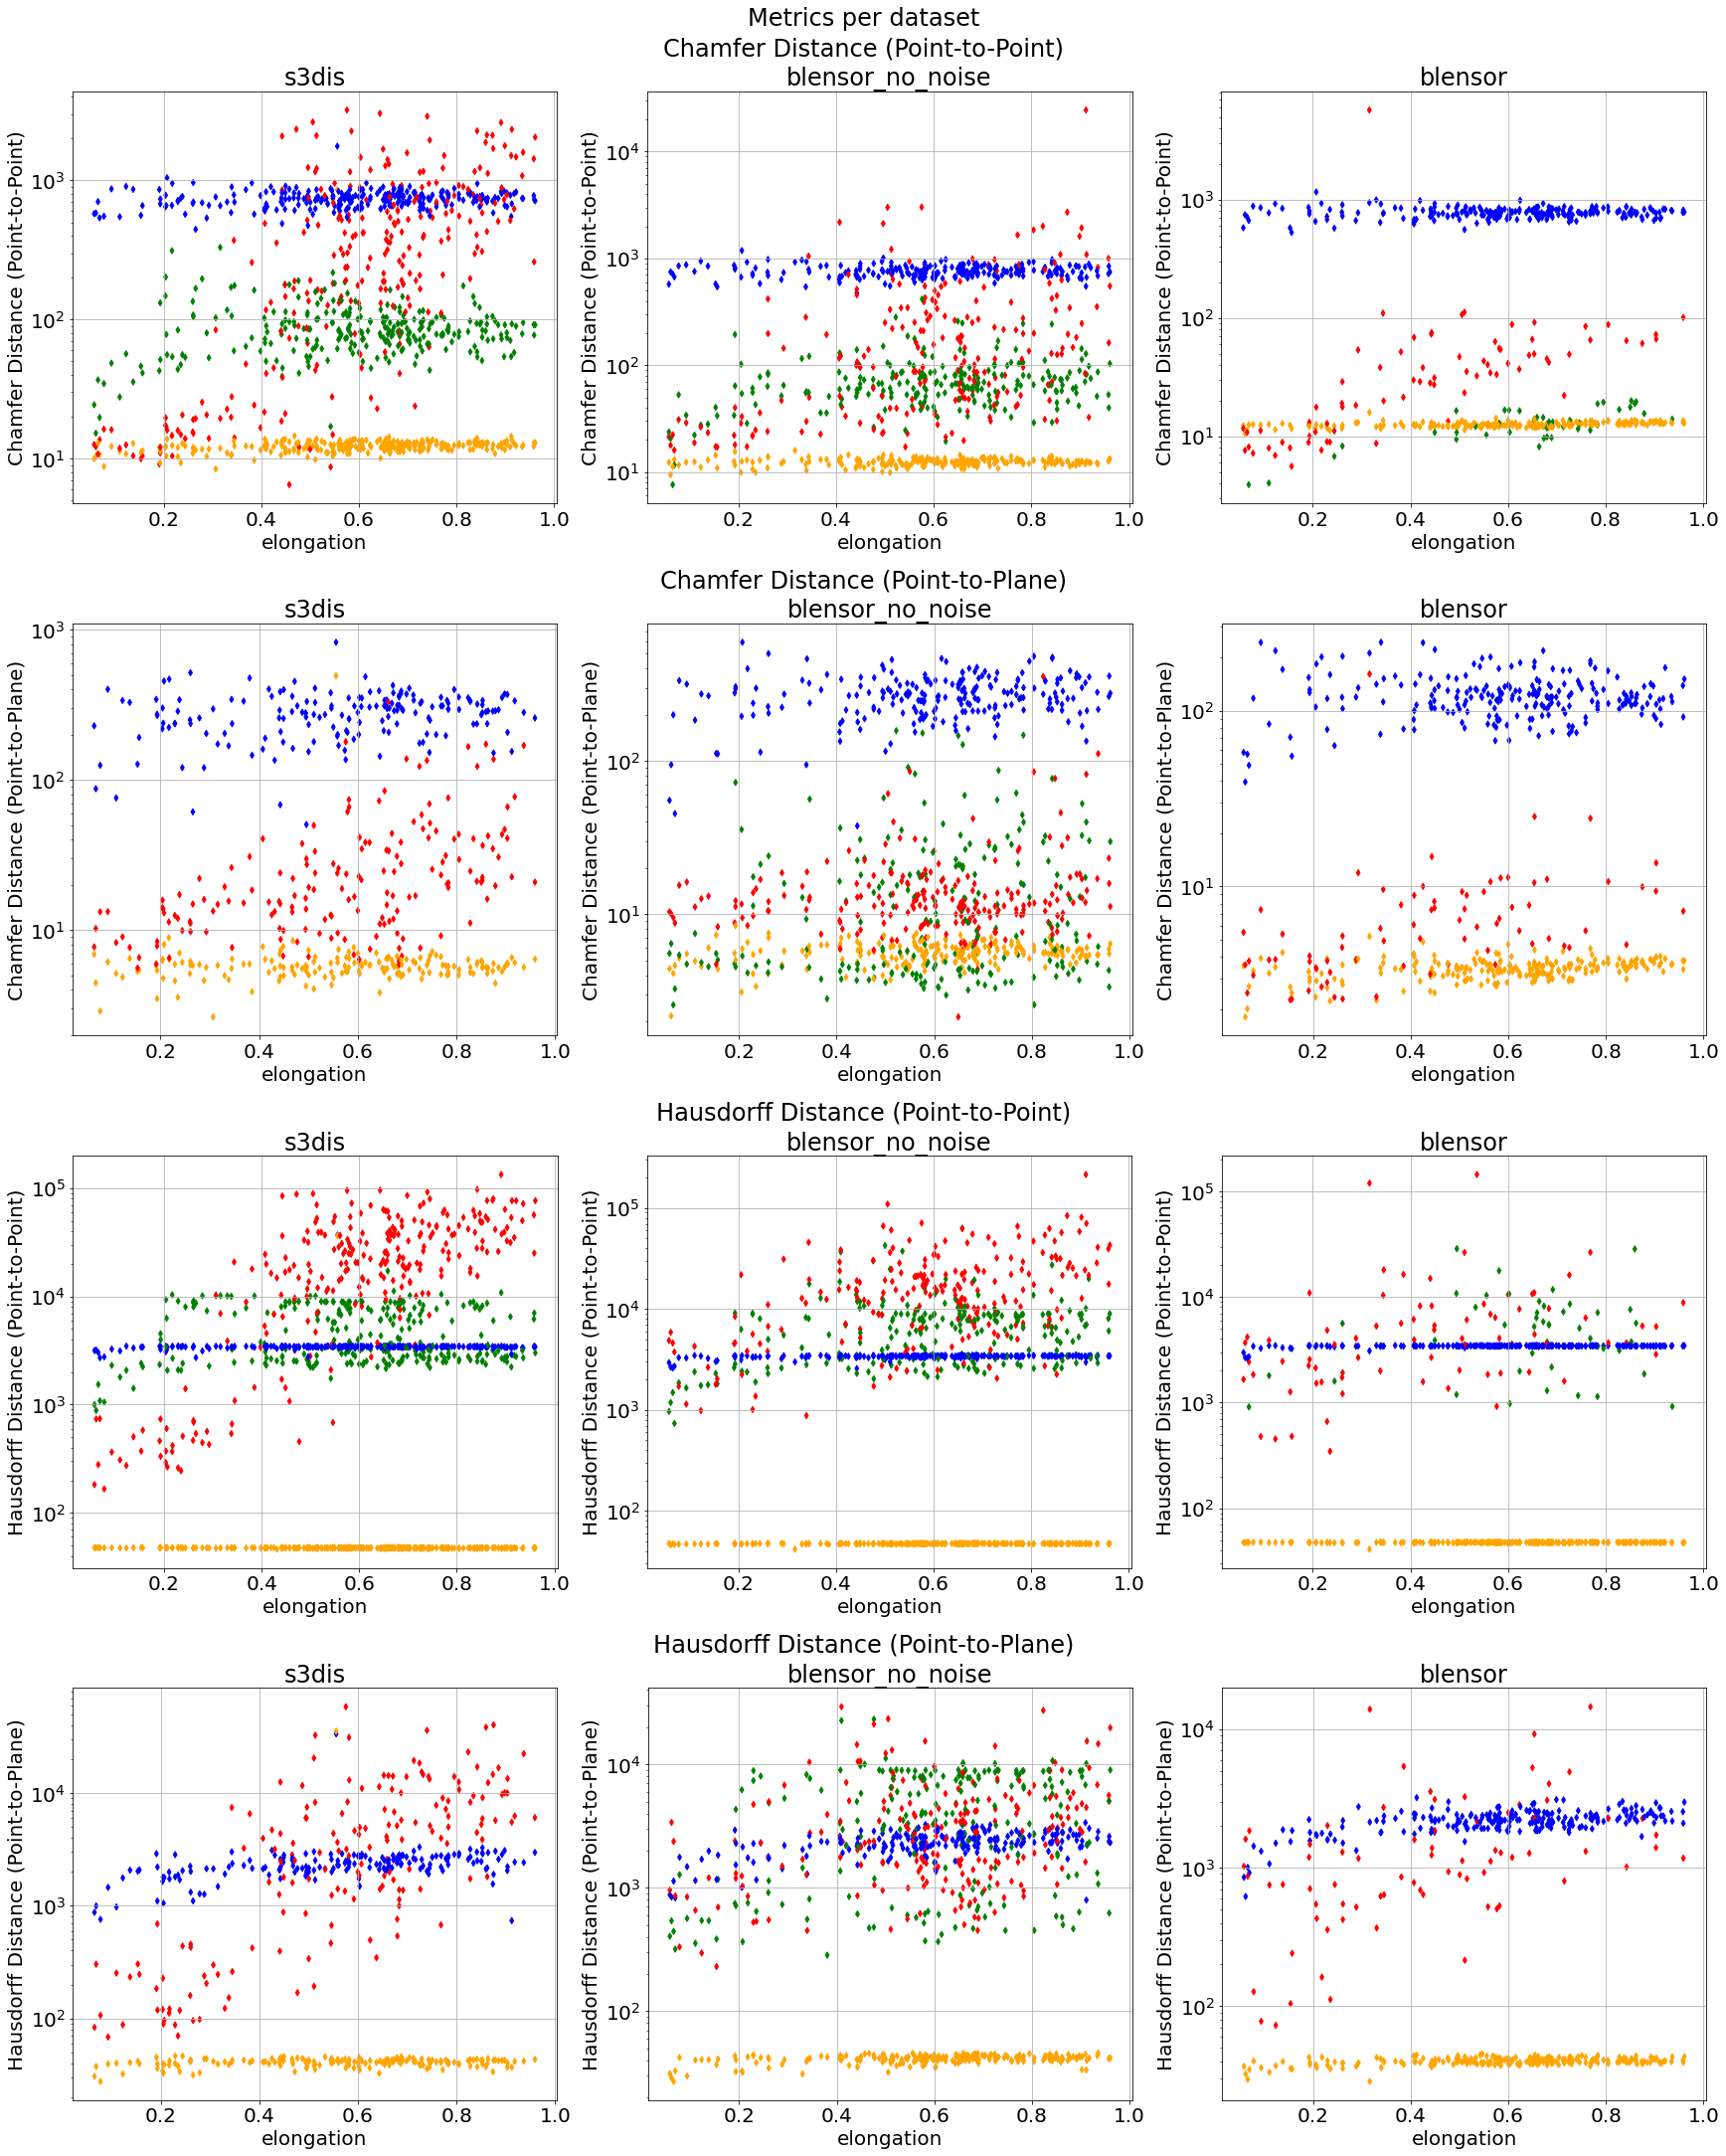

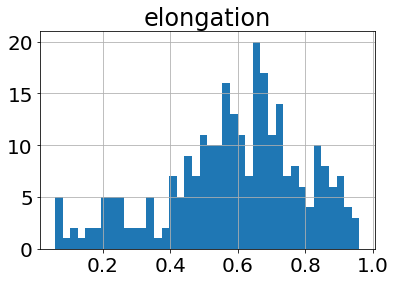

In [682]:
summary = pd.read_hdf('data_with_elongations.h5', key='e')
datasets = ["s3dis", "blensor_no_noise", "blensor"]

col2label = {
    "cd_p2pt": "Chamfer Distance (Point-to-Point)",
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
    "h_p2pt": "Hausdorff Distance (Point-to-Point)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)"
}

relevant_cols = list(col2label.keys())
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(24)
fig.set_figheight(30)
fig.tight_layout()
fig.suptitle("Metrics per dataset")
print(summary[summary["datasets"] == "s3dis"]["pc_file"].iloc[0])
alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

alg2color = {
    "Draco": "blue",
    "GPCC": "orange",
    "PCGCv1": "green",
    "PCGCv2": "red",
    "GeoCNNv1": "black",
    "GeoCNNv2": "grey"
}

subfigs = fig.subfigures(nrows=len(relevant_cols), ncols=1)

# First, plot histogram of the elongation spread
ax = summary[["room", "elongation"]].drop_duplicates().dropna().hist( column="elongation", bins=40)
# ax.set_title("Histogram of room elongations")
# we can see that they are mostly relatively compact rooms (offices)
# display(summary[(summary["algs"] == "Draco") & (summary["rate"] == "r2") & (summary["datasets"] == "blensor") & (summary["cd_p2pl"].notna())])
# plt.figure(constrained_layout=True)
# Second, across all rooms, all algos, plot elongation against Chamfer Distance
# for algo in ["Draco", "GPCC", "PCGCv1", "PCGCv2"]:
#     summary[summary["algs"] == algo].plot(kind="scatter", x="elongation", y="h_p2pl", c=alg2color[algo])
# found no discernible difference with the elongation

for i, subfig in enumerate(subfigs):
    col = relevant_cols[i]
    axs = subfig.subplots(nrows=1, ncols=len(datasets))
    subfig.suptitle(f'{col2label[col]}')
    for j, ax in enumerate(axs):
        dataset = datasets[j]
        filtered = summary[(summary.datasets == dataset) & (summary.rate == "r1")]
        filtered.plot(ax=ax, x="elongation", y=col, c=filtered['algs'].map(alg2color), title=dataset, kind="scatter", logy=True, marker=alg2marker[alg], ylabel=col2label[col], grid=True)

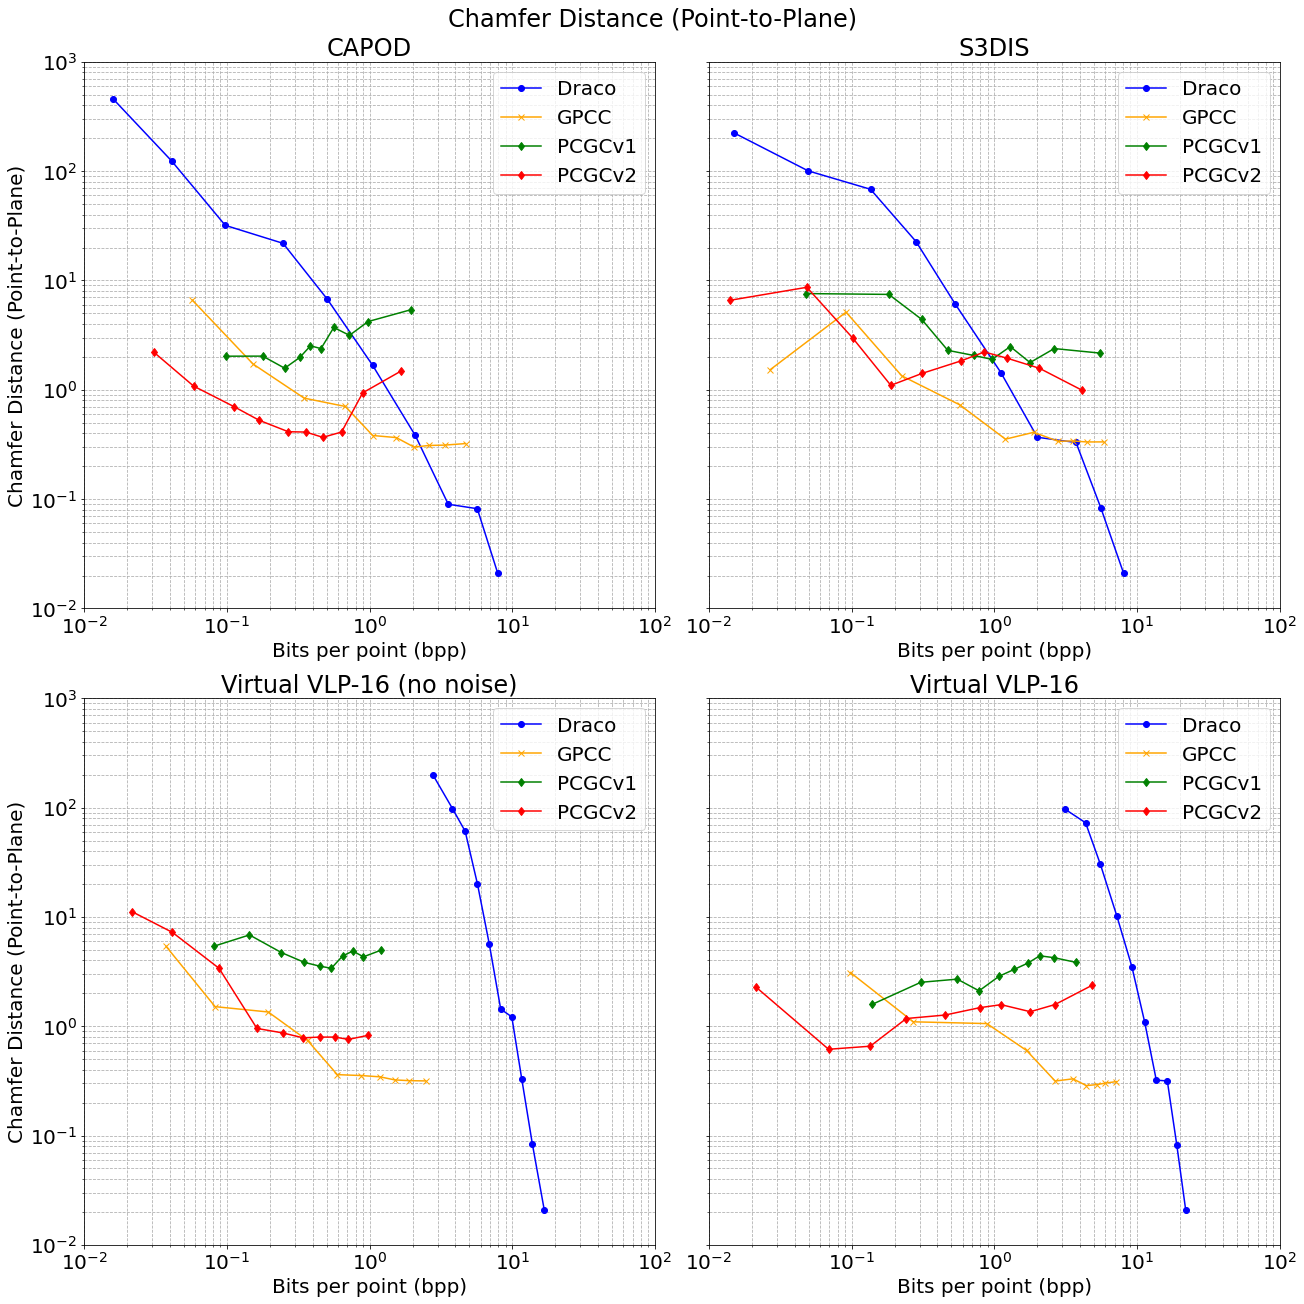

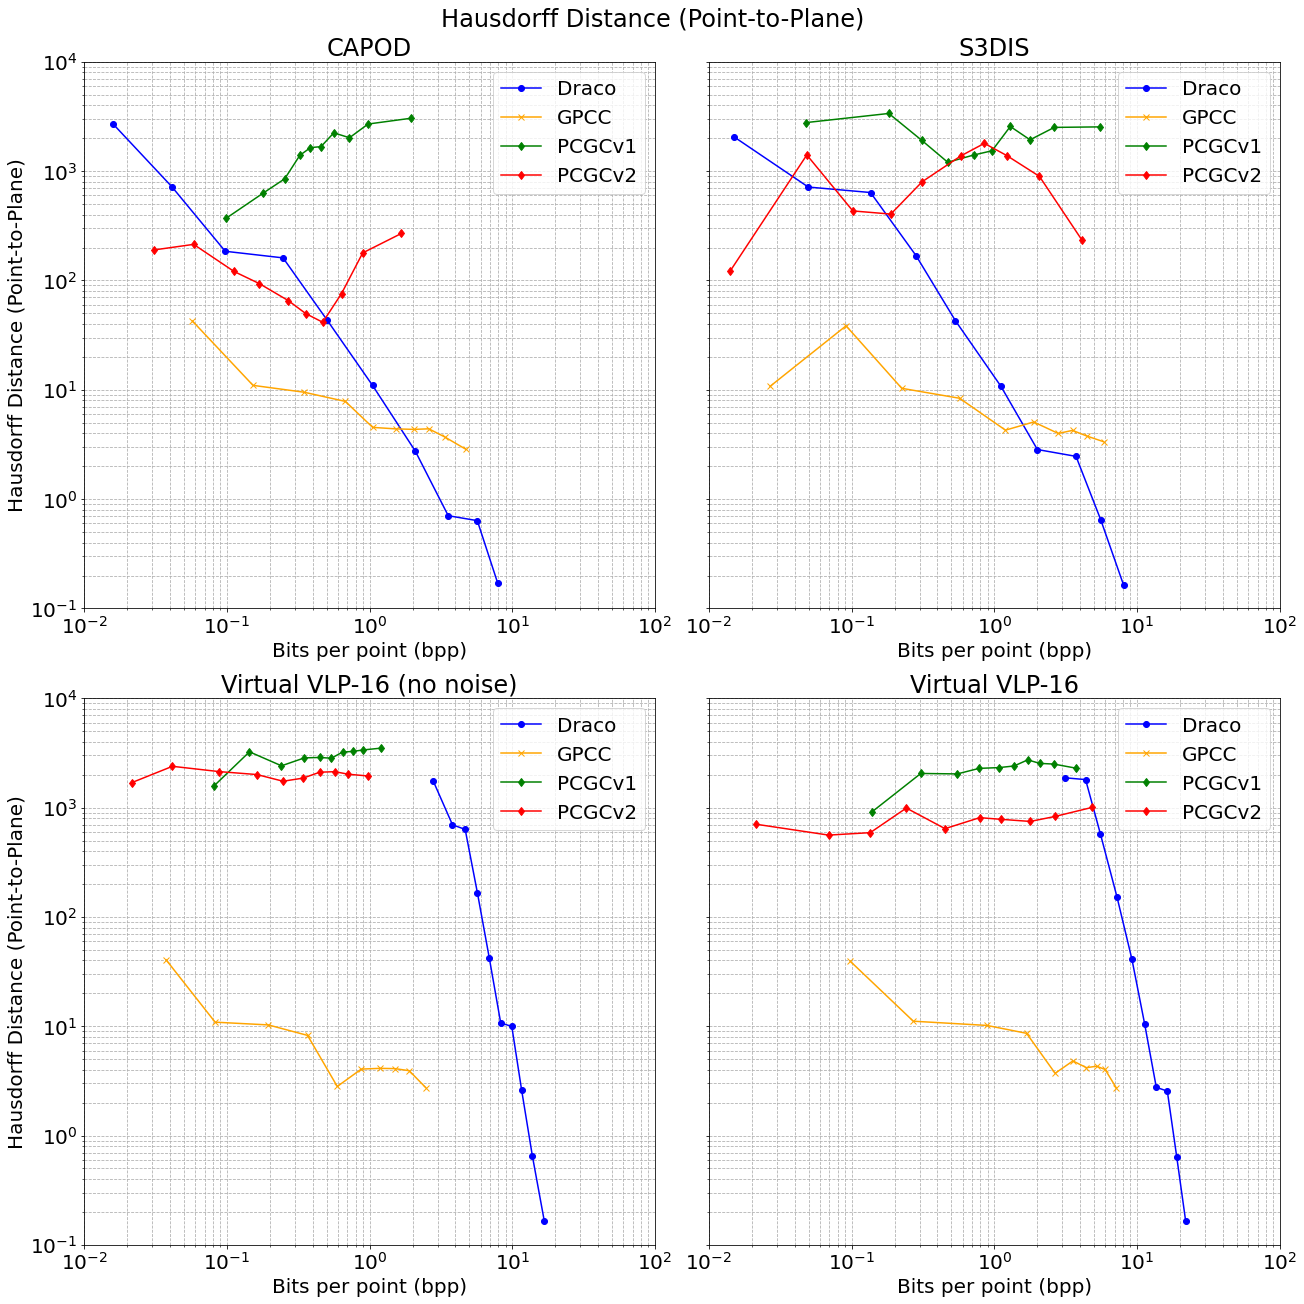

In [677]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")


col2label = {
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)"
}
datasets = ["CAPOD", "s3dis", "blensor_no_noise", "blensor"]

relevant_cols = list(col2label.keys())

dataset2label = {
    "CAPOD": "CAPOD",
    "s3dis": "S3DIS",
    "blensor_no_noise": "Virtual VLP-16 (no noise)",
    "blensor": "Virtual VLP-16"
}

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}
alg2color = {
    "Draco": "blue",
    "GPCC": "orange",
    "PCGCv1": "green",
    "PCGCv2": "red",
    "GeoCNNv1": "black",
    "GeoCNNv2": "grey"
}

summary = summary[(summary["cd_p2pl"].notna()) & (summary["h_p2pl"].notna())]
summary = summary.set_index(["algs", "datasets", "rate"])
for col in relevant_cols:
    fig, axes = plt.subplots(figsize=(18, 18), nrows=2, ncols=2, constrained_layout=True, sharey=True)
    fig.suptitle(col2label[col])
    for i, dataset in enumerate(datasets):   
        filtered = summary[summary.index.isin([dataset], level=1)].reset_index()
        for key, grp in filtered.groupby(['algs']):
            grp = grp[["bpp", col]].reset_index()        

            bins = pd.qcut(grp['bpp'], 10)
            means = grp.groupby(bins).median()
            use_log,ylim, yticks, xlim, xticks = get_plot_config(col, limit=False)
            ylim = (0.1, 10000) if "h_" in col else (0.01, 1000)
            this_ax = means.plot(ax=axes[i//2, i%2], title=dataset2label[dataset], kind="line", c=alg2color[key], xlim=(0.01, 100), x='bpp', logy=True, logx=True, ylim=ylim, xticks=xticks, yticks=yticks, y=col, marker=alg2marker[key], ylabel=col2label[col],label=key)
            this_ax.set_xlabel("Bits per point (bpp)")
            this_ax.yaxis.grid(True, which='both', linestyle='--')
            this_ax.xaxis.grid(True,  which='both', linestyle='--')
    fig.savefig(f"plots/arena_{col}_per_bpp.png", bbox_inches='tight', pad_inches=1)



/itf-fi-ml/home/branisj/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/itf-fi-ml/home/branisj/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/itf-fi-ml/home/branisj/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/itf-fi-ml/home/branisj/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


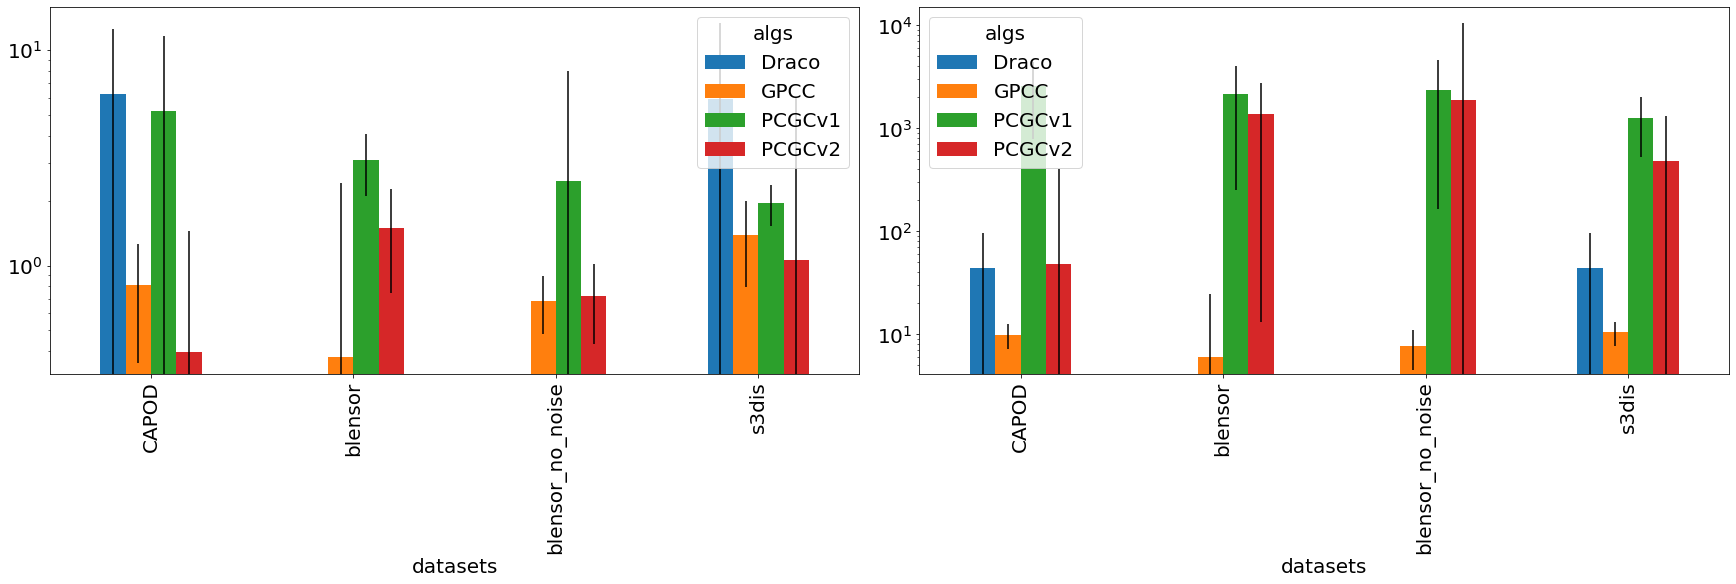

In [470]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")


col2label = {
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)"
}
datasets = ["CAPOD", "s3dis", "blensor_no_noise", "blensor"]

relevant_cols = list(col2label.keys())
fig, axes = plt.subplots(figsize=(24, 8), nrows=1, ncols=2, constrained_layout=True)

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}
alg2color = {
    "Draco": "blue",
    "GPCC": "orange",
    "PCGCv1": "green",
    "PCGCv2": "red",
    "GeoCNNv1": "black",
    "GeoCNNv2": "grey"
}

summary = summary.set_index(["algs", "datasets"])
for i, ax in enumerate(axes):
    col = relevant_cols[i]
    df = summary[summary[col].notna()]
    df = df[["bpp", col]]
    close = df[np.isclose(df["bpp"], 0.5, atol=0.01)].reset_index()
    medians = close.groupby(["algs", "datasets"]).median()[col]
    stds = close.groupby(["algs", "datasets"]).std()[col]
    pivoted = medians.reset_index().pivot(index="datasets", columns='algs', values=col)
    pivoted_std = stds.reset_index().pivot(index="datasets", columns='algs', values=col)
    pivoted.plot(ax=ax, yerr=pivoted_std, kind="bar", logy=True,)

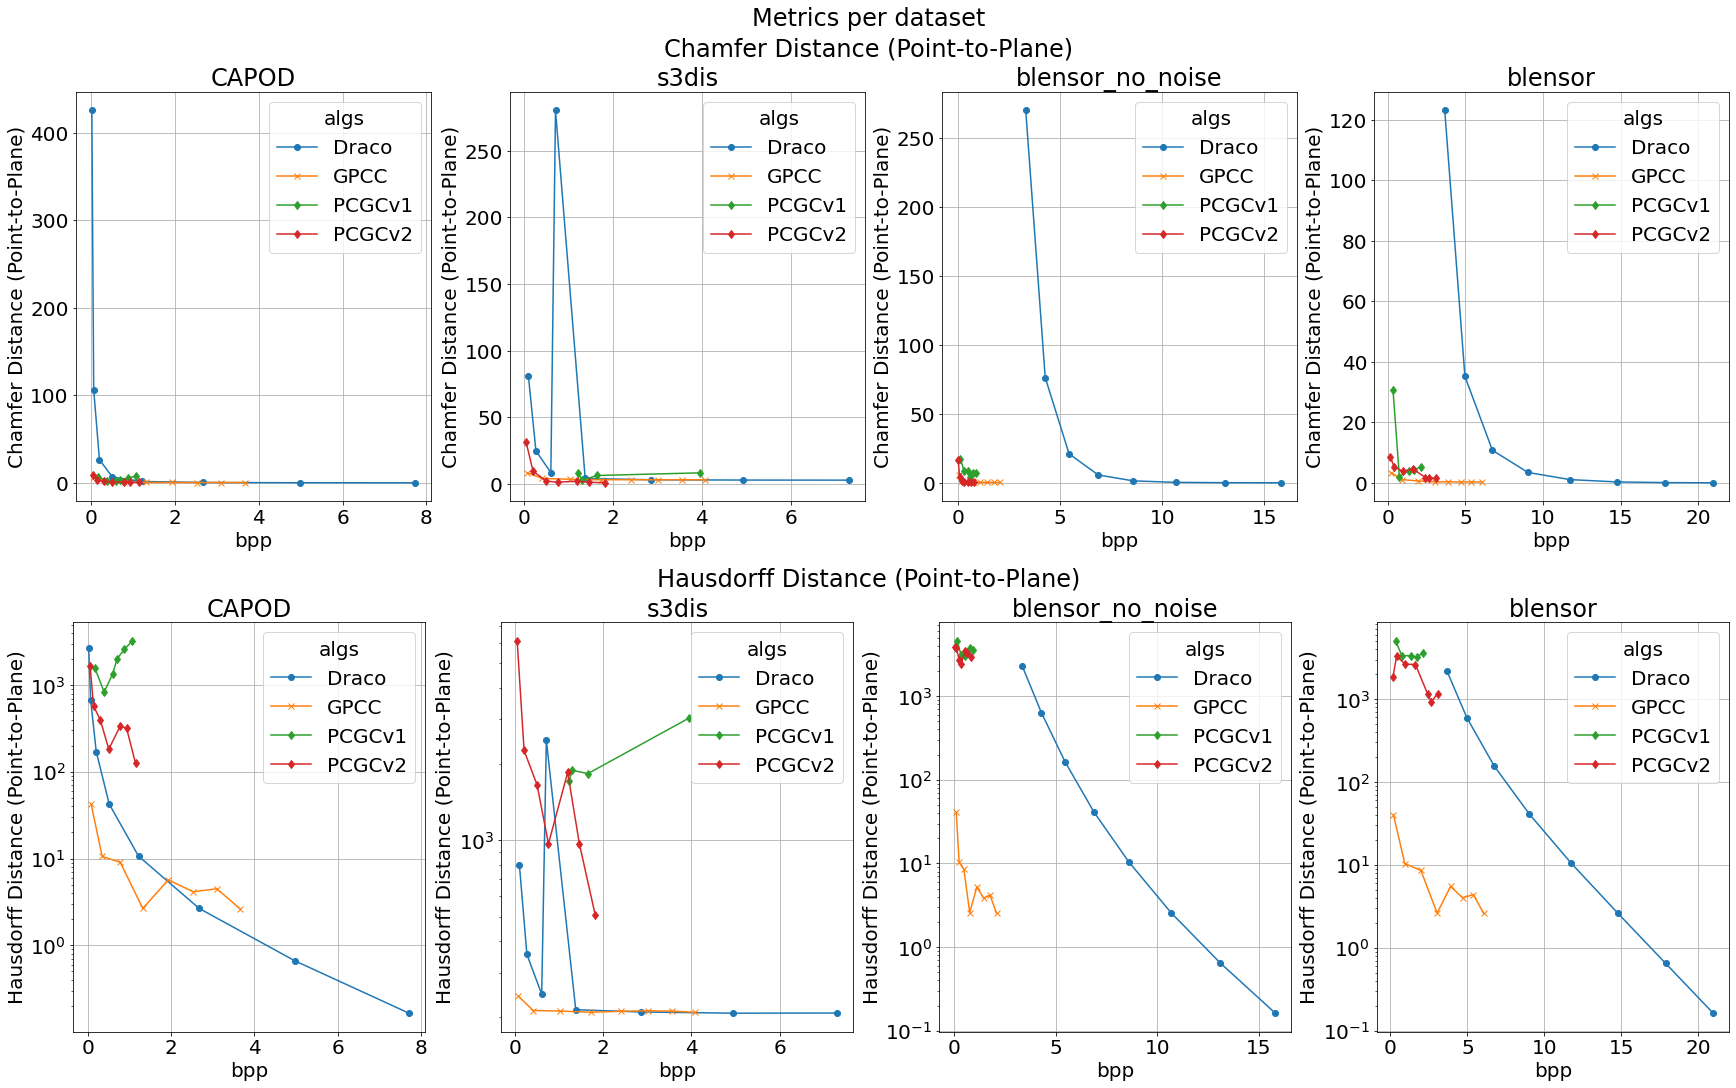

In [427]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")


col2label = {
#     "acd12_p2pt": "Assymetric Chamfer Distance 1-2 (Point-to-Point)",
#     "acd12_p2pl": "Assymetric Chamfer Distance 1-2 (Point-to-Plane)",
#     "acd21_p2pt": "Assymetric Chamfer Distance 2-1 (Point-to-Point)",
#     "acd21_p2pl": "Assymetric Chamfer Distance 2-1 (Point-to-Plane)",

#     "cd_p2pt": "Chamfer Distance (Point-to-Point)",
    "cd_p2pl": "Chamfer Distance (Point-to-Plane)",
#     "h_p2pt": "Hausdorff Distance (Point-to-Point)",
    "h_p2pl": "Hausdorff Distance (Point-to-Plane)"

}
datasets = ["CAPOD", "s3dis", "blensor_no_noise", "blensor"]


relevant_cols = list(col2label.keys())
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(24)
fig.set_figheight(15)
fig.tight_layout()
fig.suptitle("Metrics per dataset")

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

subfigs = fig.subfigures(nrows=len(relevant_cols), ncols=1)



for i, subfig in enumerate(subfigs):
    col = relevant_cols[i]
    axs = subfig.subplots(nrows=1, ncols=len(datasets))
    subfig.suptitle(f'{col2label[col]}')
    for j, ax in enumerate(axs):
        dataset = datasets[j]
        filtered = summary[summary.datasets == dataset]
        groups = filtered.groupby(['algs', 'rate'])
        means = groups.mean()
        std = groups.std()
        std["bpp"] = means["bpp"]

        means = means.reset_index()
        std = std.reset_index()
#         display(means)
    

   
        for alg in ['Draco', 'GPCC', 'PCGCv1', 'PCGCv2']:
            _means = means[means["algs"] == alg]
            _std = std[std["algs"] == alg]
            pivoted_means = _means.pivot(index='bpp', columns='algs', values=col)
            pivoted_std = _std.pivot(index='bpp', columns='algs', values=col)   
            use_log,ylim, yticks, xlim, xticks = get_plot_config(col, limit=False)            
            if pivoted_means.size > 0:
                pivoted_means.plot(ax=ax, title=dataset, yticks=yticks, xticks=xticks, kind="line", marker=alg2marker[alg], ylim=ylim, xlim=xlim, logy=use_log, ylabel=col2label[col], grid=True)

# fig.savefig("plots/pcc_acd.png", bbox_inches='tight', pad_inches=1)